In [1]:
#This is the qfuncts

import numpy as np
from numpy import identity as eye, trace, kron

#### error builder functions, for the matrix checks
#Defining recursivly
#This is how you choose your protecton
def kron_eye(n):
    I = eye(2)
    tI = I.copy()
    for i in range(n-1):
        I = kron(I, tI)
    return(I)
def eX(n):
    x = np.array([[0, 1],[1, 0]])
    tx = np.array(x, copy=True)
    for i in range(n-1):
        x = kron(x, tx)
    return(x)
def eY(n):
    y = np.array([[0, -1j], [1j, 0]])
    ty = np.array(y, copy=True)
    for i in range(n-1):
        y = kron(y, ty)
    return(y)
def eZ(n):
    z = np.array([[1, 0], [0, -1]])
    tz = np.array(z, copy=True)
    for i in range(n-1):
        z = kron(z, tz)
    return(z)


#### encoding functions for matrix checks
def Error(A, E):
    return(np.dot(np.dot(E, A), E)) # E.T gives - for Ys
def encode(P, A):
    return(np.dot(np.dot(P, A), P.T))
def decode(P, B):
    return(np.dot(np.dot(P.T, B), P))


#### retrieve rho
def partial_trace(A):
    """ only does trace 1 for now """
    n, m = A.shape
    if n != m:
        print("squares for now")
        return(1)
    a = A[:n//2, :n//2]
    #b = A[:n//2, n//2:]
    #c = A[n//2:, :n//2]
    d = A[n//2:, n//2:]
    if np.log2(n) % 2 == 1: # if odd
        return(np.add(a, d))
    else: # two sigmas need getting rid
        return(partial_trace(np.add(a, d)))
    
    
#### floating point cleanup
def round_error(A, B):
    total = np.sum(A - B)
    return(np.abs(total) < 0.001)


#### recursively build teh circuit
def build_circ(qc, q, E):
    
    n = q[-1][1] + 1# highest qubit
    def err(e, base=False):
        d = {'X':qc.x, 'Y':qc.y, 'Z':qc.z, 'I':lambda x: None}
        d[e](q[n-1])
        if base: # if we're at q3
            d[e](q[0])
            d[e](q[1])
    
    if n % 2 == 0: # qn is even
        qc.cx(q[n-2], q[n-1])
        qc.h(q[n-2])
        qc.cx(q[n-2], q[n-1])
        build_circ(qc, q[:-1], E)
        err(E)
        qc.cx(q[n-2], q[n-1])
        qc.h(q[n-2])
        qc.cx(q[n-2], q[n-1])
    else: # it's odd
        qc.cx(q[n-1], q[n-2])
        qc.cx(q[n-3], q[n-1])
        qc.cx(q[n-2], q[n-3])
        if n == 3: # base case
            err(E, True)
        else:
            build_circ(qc, q[:-1], E)
            err(E)
        qc.cx(q[n-2], q[n-3])
        qc.cx(q[n-3], q[n-1])
        qc.cx(q[n-1], q[n-2])
    return()


#### recursively build the P matrix
def build_u(N):
    if N == 2:
        return(np.array([[ 1, 0, 0, 1],
                      [ 0,-1, 1, 0],
                      [ 0, 1, 1, 0],
                      [ 1, 0, 0,-1]])/np.sqrt(2))
    elif N == 3:
        return(np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 0, 1],
                       [0, 0, 0, 0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 1, 0],
                       [0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0]]))
    elif N % 2 == 0:
        return(np.dot(kron(eye(2), build_u(N-1)), kron(build_u(2), kron_eye(N-2))))
    else:
        return(np.dot(kron(kron_eye(2), build_u(N-2)), kron(build_u(3), kron_eye(N-3))))

In [2]:
import qiskit 

In [3]:
from qiskit import IBMQ

In [5]:
IBMQ.save_account('1b35af4ebcdf9bf56fc5d6a67fcfcc94adb1b0f268bf7bfe47427d294829b740737483e37f5c7dc2941bdfd0a4847baeb44b78867a91e65c39e35c89cf5309b2', overwrite=True)

In [6]:
#Imports that work.  Assuming everything else has been ported to Qiskit Standard
from numpy import identity as eye, trace, kron
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, \
    BasicAer, execute, IBMQ, __qiskit_version__

from qiskit.providers.aer import noise

from qiskit.quantum_info import Pauli, state_fidelity, basis_state, \
    process_fidelity, random_state, projector

from qiskit.tools.visualization import plot_histogram

import glob
import PIL 

In [7]:
#Simulators
statevec = BasicAer.get_backend('statevector_simulator')
unitary = BasicAer.get_backend('unitary_simulator')
qasm = BasicAer.get_backend('qasm_simulator')

In [8]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')

In [9]:
#Setting up Acutal quantum Backends.  Missing ibmqx4.  


try:
    ibmqx2 = provider.get_backend('ibmqx2')
except:
    IBMQ.load_account()
    ibmqx2 = provider.get_backend('ibmqx2')

In [10]:
#Now begins the simulating

In [11]:
#Setup Quantum System
q2 = QuantumRegister(2)
c2 = ClassicalRegister(2)
qc2 = QuantumCircuit(q2, c2)


In [12]:
#I think that this is encoding everything using hadimar and control x gates

# encode
#qc2.cx(q2[0],q2[1])
qc2.cx(q2[0], q2[1])
qc2.h(q2[0])
qc2.cx(q2[0], q2[1])

In [13]:
#Somehow acting on the superimposed system with a unitary matrix??  
#I think this is simulating the result of the system going through the device.  

P2 = execute(qc2, unitary).result().get_unitary(qc2)

qc2.z(q2)

In [14]:
#His comment is self explanitory.  Decodeing according to Prof's Theory.  

# decode
qc2.cx(q2[0], q2[1])
qc2.h(q2[0])
qc2.cx(q2[0], q2[1])


In [15]:
#Measuring.  Collapses the superimposition.  

qc2.measure(q2, c2)

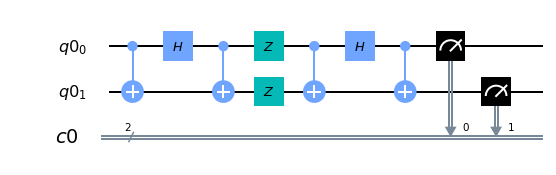

In [16]:
#This draws the circuit
qc2.draw()
qc2.draw(output="mpl")

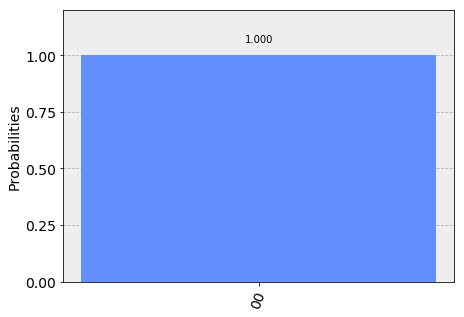

In [17]:
#This exicutes it in a sim. and plots the results
res2=execute(qc2, qasm).result()
r2c = res2.get_counts(qc2)
plot_histogram(r2c)

In [18]:
#Done with the 2 cubit circuit, onto the 3 case.  

In [19]:
#I think that this is some probubility dist.
def randomrho(k):
    rho_2 = random_state(2**k)
    rho2h = {}
    for i, prob in enumerate(list(map(lambda x: abs(x * x), rho_2))):
        rho2h[format(i, '0%sb' % 2)] = prob

In [20]:
#Defining the circuit

q3 = QuantumRegister(3)
c3 = ClassicalRegister(2)
qc3 = QuantumCircuit(q3, c3)

In [21]:
#Isn't working since rho_2 isn't defined.  
#Edit, Define Rho_2 as follows from the bottom of code.

#stt = format(0, '0%sb' % 2)
#rho_2 = basis_state(stt, 2)

#Activate thingy
#qc3.initialize(rho_2, [q3[0], q3[1]])

#Does some weird stuff.  Big purple box.  Trying to re-run the whole program.  
#nope, big purple box is still there.  

#Trying again with the rho_2 grabbed from qcc_4
rho_2 = random_state(2**2)

#looks better, adding in the thingy

qc3.initialize(rho_2, [q3[0], q3[1]])

#Now it's just a bigger purple box with numbers in it.  

#Leaving it in comments until I ask.  

In [22]:
#This works?  maybe?
build_circ(qc3, q3, 'X')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: Accessing a bit register by bit[0] or its index by bit[1] is deprecated. Go for bit.register and bit.index.


()

In [23]:
#Measure, duh
qc3.measure(q3[:2], c3);

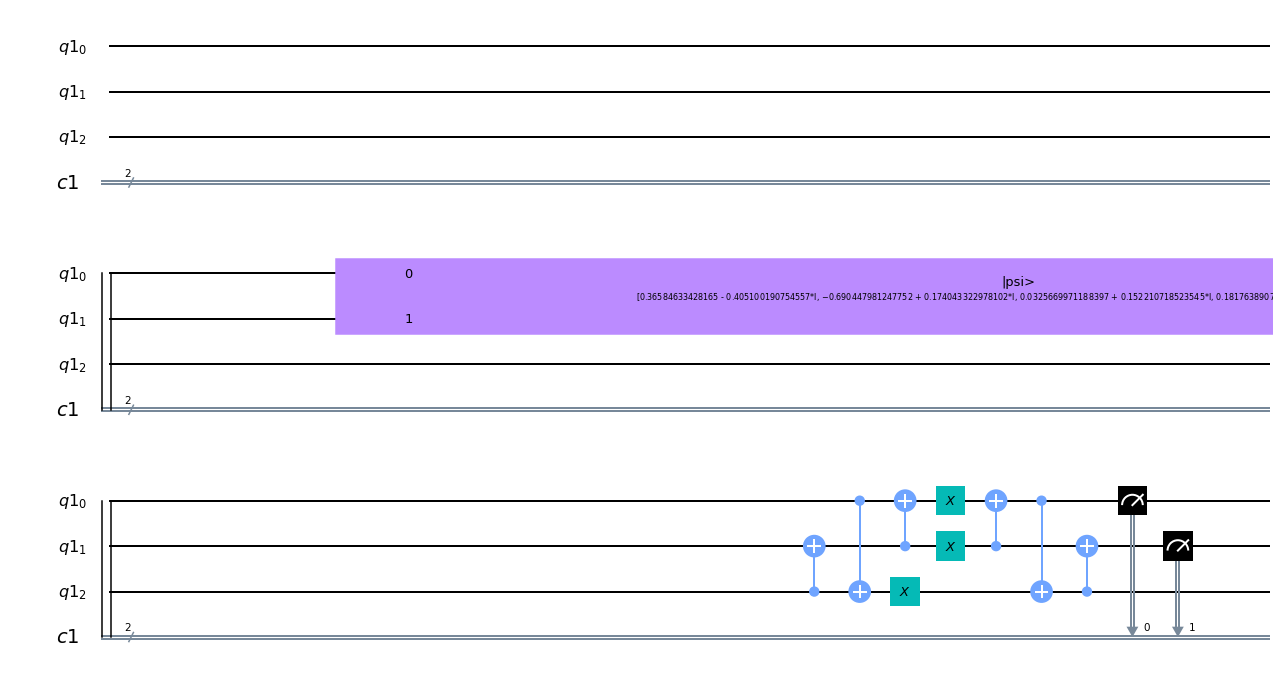

In [24]:
qc3.draw(output="mpl")

In [0]:
#I have no idea why there is 4 of them.  
#Fixed after a re-run of the whole system.  
#The Build Circ. command stacks up.  Watch out!  

In [0]:
#My system just crashed after doing a little bit of the next part.  
#Either my SSD is going or I forgot to set memory limits. Edit: It was the memory.   

In [0]:
#Run simulator
res3 = execute(qc3, qasm, shots=10000).result()

In [0]:
#Count up the data
ct3 = res3.get_counts(qc3)

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

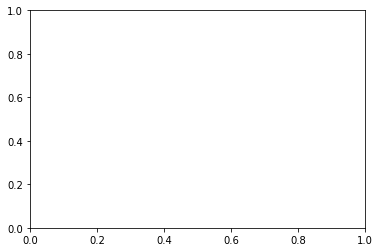

In [0]:
#Plot it all using matplotlib


plt.bar(ct3, ct3.values())

plt.show()

